<a href="https://colab.research.google.com/github/plaban1981/FASTAI_2021/blob/main/Lesson_4_Practical_Deep_Learning_for_Coders_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective : 

* Determine if two contexts represent the same thing
* For the following text...: "TEXT1: abatement; TEXT2: eliminating process" ...chose a category of meaning similarity: "Different; Similar; Identical".

##UlmFit
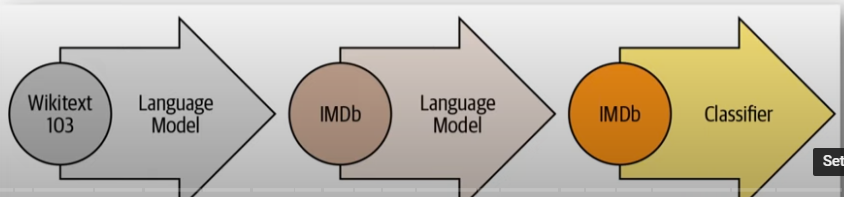

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
from fastai.vision.all import *

In [3]:
from pathlib import Path
path = Path("/content/drive/MyDrive/NLP_Fastai")
path.ls()

(#2) [Path('/content/drive/MyDrive/NLP_Fastai/train.csv'),Path('/content/drive/MyDrive/NLP_Fastai/test.csv')]

In [4]:
!ls {path}

test.csv  train.csv


## Import data

In [5]:
import pandas as pd
import numpy as np
df = pd.read_csv(path/'train.csv')
df.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [6]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [7]:
df.shape

(36473, 5)

* We could represent the input to the model as something like "TEXT1: abatement; TEXT2: eliminating process".
* We'll need to add the context to this too. In Pandas, we just use + to concatenate, like so:

In [8]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor
df.head()

,id,anchor,target,context,score,input
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,TEXT1: A47; TEXT2: act of abating; ANC1: abatement
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,TEXT1: A47; TEXT2: active catalyst; ANC1: abatement
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,TEXT1: A47; TEXT2: eliminating process; ANC1: abatement
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,TEXT1: A47; TEXT2: forest region; ANC1: abatement


In [9]:
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement
1            TEXT1: A47; TEXT2: act of abating; ANC1: abatement
2           TEXT1: A47; TEXT2: active catalyst; ANC1: abatement
3       TEXT1: A47; TEXT2: eliminating process; ANC1: abatement
4             TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

## Transformers

In [11]:
!pip install --no-cache-dir transformers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 2.1 MB/s 
     |████████████████████████████████| 1.3 MB 65.3 MB/s 
     |████████████████████████████████| 120 kB 83.2 MB/s 
     |████████████████████████████████| 6.6 MB 65.0 MB/s 


In [12]:
!pip install -q datasets

     |████████████████████████████████| 431 kB 2.1 MB/s 
     |████████████████████████████████| 115 kB 54.9 MB/s 
     |████████████████████████████████| 212 kB 50.8 MB/s 
     |████████████████████████████████| 127 kB 67.2 MB/s 


In [13]:
from datasets import Dataset,DatasetDict
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

* A deep learning model expects numbers as inputs, not English sentences! So we need to do two things:

* Tokenization: Split each text up into words (or actually, as we'll see, into tokens)
* Numericalization: Convert each word (or token) into a number.

In [14]:
model_nm = 'microsoft/deberta-v3-small'

* tokenizer needs sentencepiece to be installed. 

In [15]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
from transformers import AutoModel
#
model = AutoModel.from_pretrained("microsoft/deberta-v3-small")
tokz = AutoTokenizer.from_pretrained(model_nm)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:447: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [16]:
tokz.tokenize("G'day folks, I'm Jeremy from fast.ai!")

['▁G',
 "'",
 'day',
 '▁folks',
 ',',
 '▁I',
 "'",
 'm',
 '▁Jeremy',
 '▁from',
 '▁fast',
 '.',
 'ai',
 '!']

* Uncommon words will be split into pieces. 
* The start of a new word is represented by ▁

In [17]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['▁A',
 '▁platypus',
 '▁is',
 '▁an',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

## A simple function which tokenizes our inputs

In [18]:
def tok_func(x):
  return tokz(x["input"])

In [19]:
tok_ds = ds.map(tok_func, batched=True)

  0%|          | 0/37 [00:00<?, ?ba/s]

* This adds a new item to our dataset called input_ids. 

In [20]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

In [21]:
pd.DataFrame(tok_ds).head()

,id,anchor,target,context,score,input,input_ids,token_type_ids,attention_mask
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement,"[1, 54453, 435, 294, 336, 5753, 346, 54453, 445, 294, 47284, 265, 6435, 346, 23702, 435, 294, 47284, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,TEXT1: A47; TEXT2: act of abating; ANC1: abatement,"[1, 54453, 435, 294, 336, 5753, 346, 54453, 445, 294, 1727, 265, 266, 17441, 510, 346, 23702, 435, 294, 47284, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,TEXT1: A47; TEXT2: active catalyst; ANC1: abatement,"[1, 54453, 435, 294, 336, 5753, 346, 54453, 445, 294, 1636, 14930, 346, 23702, 435, 294, 47284, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,TEXT1: A47; TEXT2: eliminating process; ANC1: abatement,"[1, 54453, 435, 294, 336, 5753, 346, 54453, 445, 294, 10181, 568, 346, 23702, 435, 294, 47284, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,TEXT1: A47; TEXT2: forest region; ANC1: abatement,"[1, 54453, 435, 294, 336, 5753, 346, 54453, 445, 294, 4054, 1488, 346, 23702, 435, 294, 47284, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


#### task is to predict which anchor and target pair are talking about the same thing

In [22]:
tok_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

In [23]:
row = tok_ds[0]
row['input'], row['input_ids'],row['token_type_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
tokz.vocab['▁pollution']

6435

* Finally, we need to prepare our labels. Transformers always assumes that your labels has the column name labels, but in our dataset it's currently score. Therefore, we need to rename it:

In [41]:
tok_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

In [25]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

In [26]:
tok_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

## Test and validation sets

In [27]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


In [28]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

## Test Set

In [29]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [30]:
eval_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36
})

* Transformers expects metrics to be returned as a dict, since that way the trainer knows what label to use, so let's create a function to do that:

In [31]:
def corr(x,y):
  return np.corrcoef(x,y)[0][1]
def corr_d(eval_pred):
  return {'pearson': corr(*eval_pred)}

In [32]:
def show_corr(df, a, b):
    x,y = df[a],df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r: {corr(x, y):.2f}')

## Training the model

In [33]:
from transformers import TrainingArguments,Trainer

In [34]:
bs = 128
epochs = 4
lr = 8e-5

In [35]:
args = TrainingArguments('outputs', 
                         learning_rate=lr, 
                         warmup_ratio=0.1, 
                         lr_scheduler_type='cosine', 
                         fp16=True,
                         evaluation_strategy="epoch", 
                         per_device_train_batch_size=bs, 
                         per_device_eval_batch_size=bs*2,
                         num_train_epochs=epochs, 
                         weight_decay=0.01, 
                         report_to='none')

* in this case it is being treated as a regression problem hence num_labels =1


In [36]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)


Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [38]:
trainer = Trainer(model, 
                  args, 
                  train_dataset=dds['train'], 
                  eval_dataset=dds['test'],
                  tokenizer=tokz,
                  compute_metrics=corr_d)

Using cuda_amp half precision backend


In [39]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, target, input, id, context. If anchor, target, input, id, context are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 27354
  Num Epochs = 4
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 856
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` met

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.026049,0.798084
2,No log,0.024597,0.822589
3,0.036400,0.023750,0.830213
4,0.036400,0.022939,0.832610


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, target, input, id, context. If anchor, target, input, id, context are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, target, input, id, context. If anchor, target, input, id, context are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved 

TrainOutput(global_step=856, training_loss=0.026862074281567724, metrics={'train_runtime': 283.5557, 'train_samples_per_second': 385.871, 'train_steps_per_second': 3.019, 'total_flos': 716605488222960.0, 'train_loss': 0.026862074281567724, 'epoch': 4.0})

## Make Predictions

In [40]:
preds = trainer.predict(eval_ds).predictions.astype(float)
print(type(preds))

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: anchor, target, input, id, context. If anchor, target, input, id, context are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 36
  Batch size = 256


<class 'numpy.ndarray'>


In [41]:
preds

array([[ 0.53369141],
       [ 0.671875  ],
       [ 0.59619141],
       [ 0.34960938],
       [-0.04095459],
       [ 0.5546875 ],
       [ 0.53320312],
       [ 0.02990723],
       [ 0.26025391],
       [ 1.09863281],
       [ 0.24206543],
       [ 0.27197266],
       [ 0.79492188],
       [ 0.95800781],
       [ 0.77246094],
       [ 0.578125  ],
       [ 0.28857422],
       [-0.01110077],
       [ 0.65380859],
       [ 0.38549805],
       [ 0.49267578],
       [ 0.28320312],
       [ 0.18579102],
       [ 0.2434082 ],
       [ 0.58056641],
       [-0.04116821],
       [-0.03625488],
       [-0.0329895 ],
       [-0.02307129],
       [ 0.578125  ],
       [ 0.3203125 ],
       [ 0.04769897],
       [ 0.76171875],
       [ 0.53320312],
       [ 0.49658203],
       [ 0.22998047]])

* some of our predictions are <0, or >1
* fixing the boundary predictions

In [42]:
preds = np.clip(preds, 0, 1)

In [43]:
preds

array([[0.53369141],
       [0.671875  ],
       [0.59619141],
       [0.34960938],
       [0.        ],
       [0.5546875 ],
       [0.53320312],
       [0.02990723],
       [0.26025391],
       [1.        ],
       [0.24206543],
       [0.27197266],
       [0.79492188],
       [0.95800781],
       [0.77246094],
       [0.578125  ],
       [0.28857422],
       [0.        ],
       [0.65380859],
       [0.38549805],
       [0.49267578],
       [0.28320312],
       [0.18579102],
       [0.2434082 ],
       [0.58056641],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.578125  ],
       [0.3203125 ],
       [0.04769897],
       [0.76171875],
       [0.53320312],
       [0.49658203],
       [0.22998047]])

In [44]:
preds.shape

(36, 1)

In [45]:
eval_df.head()

,id,anchor,target,context,input
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,TEXT1: G02; TEXT2: inorganic photoconductor drum; ANC1: opc drum
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,TEXT1: F23; TEXT2: altering gas flow; ANC1: adjust gas flow
2,36baf228038e314b,lower trunnion,lower locating,B60,TEXT1: B60; TEXT2: lower locating; ANC1: lower trunnion
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXT1: D06; TEXT2: upper portion; ANC1: cap component
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,TEXT1: H04; TEXT2: artificial neural network; ANC1: neural stimulation


In [46]:
eval_df['score'] = preds

In [47]:
eval_df.head()

,id,anchor,target,context,input,score
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,TEXT1: G02; TEXT2: inorganic photoconductor drum; ANC1: opc drum,0.533691
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,TEXT1: F23; TEXT2: altering gas flow; ANC1: adjust gas flow,0.671875
2,36baf228038e314b,lower trunnion,lower locating,B60,TEXT1: B60; TEXT2: lower locating; ANC1: lower trunnion,0.596191
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXT1: D06; TEXT2: upper portion; ANC1: cap component,0.349609
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,TEXT1: H04; TEXT2: artificial neural network; ANC1: neural stimulation,0.000000


In [48]:
eval_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36
})

## Make Submission

In [49]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1024